In [1]:
import numpy
import scipy.special
import scipy.ndimage
import matplotlib.pyplot
%matplotlib inline
import imageio
import glob

## Defining functions

In [2]:
# neural network class
class neuralNetwork:
    
    #initialization function to create network
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate): #these are the things we need to initialize a NN
        """
        Applies the parameters to the neural network object, network has one hidden layer.
        
        :param inputnodes: number of nodes in input layer
        :param hiddennodes: number of nodes in hidden layer
        :param outputnodes: number of nodes in output layer
        :param learningrate: learning rate of gradient descent        
        :type inputnodes: int
        :type hiddennodes: int
        :type outputnodes: int
        :type learningrate: int
        
        returns: None
        """
        #assigning these variables to the object: 
        self.inodes = inputnodes 
        self.hnodes = hiddennodes
        self.onodes = outputnodes
        self.lr = learningrate
        
        #matrix of random weigths (w) that link input layer (i) to hidden layer (h)
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        
        #matrix of random weights (w) that link hidden layer (h) to output later (o)
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))
        
        # defining the activation function, in this case the sigmoid (called expit here)
        self.activation_function = lambda x: scipy.special.expit(x)  
        
        #defining the reverse activation function for backwards query, called logit
        self.inverse_activation_function = lambda x: scipy.special.logit(x)
        
        pass
    
    # training phase
    def train(self, inputs_list, targets_list):
        """
        Coverts input to output through the network and backpropagates the error to update weights, thereby training the NN
        
        :param inputs_list: training features
        :param targets_list: training labels or target output
        :type inputs_list: list
        :type targets_list: list
        
        returns: None
        """
        
        ###part 1: going from input to output:
        
        # convert inputs list to 2d array (matrix)
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        # calculate signals into hidden layer by applying weights to inputlayer
        hidden_inputs = numpy.dot(self.wih, inputs)
        # calculate the signals emerging from hidden layer by applying activation function
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer by applying weights to output from hidden layer
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # calculate the signals emerging from final output layer by applying activation function
        final_outputs = self.activation_function(final_inputs)
        
        ###part 2: backpropagating error
        
        # output layer error is the target output minus the actual output
        #note: output_errors is still a matrix, and thus contains all the errors for every datapoint separately. targets and final_outputs are also arrays
        output_errors = targets - final_outputs
        
        # hidden layer error is the output_errors, split by weights, recombined at hidden nodes
        # so, (transposed) hidden-output weights matrix is multiplied with the output error matrix
        hidden_errors = numpy.dot(self.who.T, output_errors) 
        
        # update the weights for the links between the hidden and output layers
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
        
        # update the weights for the links between the input and hidden layers
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))
        pass
    
    # query fase
    def query(self, inputs_list):
        """
        Gives predictions based on input. 
        
        inputs_list: list 
        returns: array with output
        """
        # convert inputs_list to matrix, and transposes so input is a column not a row
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        # calculate signals into hidden layer: use matrix multiplication of weights and input
        hidden_inputs = numpy.dot(self.wih, inputs)
        # apply activation (sigmoid) to calculate what comes out of hidden layer
        hidden_outputs = self.activation_function(hidden_inputs)
        
        # calculate signals into final output layer: matrix multiplication of weights and input (in this case output from previous layer)
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # apply activation (sigmoid) to calculate what comes out of output layer
        final_outputs = self.activation_function(final_inputs)
        
        
        return final_outputs 
    
        
    # backquery the neural network
    # target are the values at the right of the network, albeit used as input
    # hidden_output is the signal to the right of the middle nodes

    def backquery(self, targets_list):
        """
        Feed the network target output and get an image back, by going backwards throught the network. 
        
        :param targets_list: list of target outputs
        :type targets_list: list
        
        returns: input (image)
        """
        # transpose the targets list to a vertical array
        # same as in query()
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # we are going backwards, so first the reverse activation function is applied
        # calculate the signal into the final output layer using the inverse act funct (see __init__())
        final_inputs = self.inverse_activation_function(final_outputs)
        
        # calculate the signal out of the hidden layer, weights matrix is transposed
        hidden_outputs = numpy.dot(self.who.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer, weights matrix is transposed
        inputs = numpy.dot(self.wih.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs
    

## Making an NN

In [82]:
# initializing
# making a nn with specific number of nodes

input_n = 784 #28*28 pixels so 784 inputs
hidden_n = 350
output_n = 10 #we have 10 target outputs so 10 output nodes
l_r = 0.1

In [83]:
n = neuralNetwork(input_n, hidden_n, output_n, l_r)

## Training the NN

In [5]:
# load the mnist training data CSV file into a list
training_data_file = open("mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

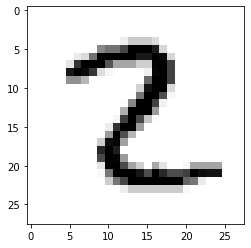

In [33]:
#plotting one of the datapoints, just to see
all_values = training_data_list[76].split(',')
image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')

In [7]:
#transforming input to inspect how it looks

# inputs_list = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
# inputs = numpy.array(inputs_list, ndmin=2).T
# print(len(inputs))
# print(inputs)

In [8]:
# transforming output to inspect how it looks

# # make array of right size (output_nodes) and fill with 0.1
# targets = numpy.zeros(10) + 0.01
# # first item in all_values is the target label for this record and should be 0.9
# targets[int(all_values[0])] = 0.99
# print(targets)

In [84]:
# train the neural network (including rotated input)

# epochs is the number of times the training data set is used for training
epochs = 5

for e in range(epochs):
    # go through all records in the training data set
    for record in training_data_list:
        # split each record on ','. all_values is list
        all_values = record.split(',')
        
        #input
        # scale and shift the inputs to be between 0.01 and 1 and is now an 1d array. leave out first item
        inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        
        # output
        # make array of right size (output_nodes) and fill with 0.01
        targets = numpy.zeros(output_n) + 0.01
        # first item in all_values is the target label for this record and should be 0.99
        targets[int(all_values[0])] = 0.99
        
        #train the network
        n.train(inputs, targets)
        
        
#         ## create rotated inputs
#         # rotated anticlockwise by x degrees
#         #make input into 28x28, rotate it
#         inputs_plusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), 10, cval=0.01, order=1, reshape=False)
#         #train with rotated input, input transformed back into 784 array
#         n.train(inputs_plusx_img.reshape(784), targets)
#         # rotated clockwise by x degrees
#         inputs_minusx_img = scipy.ndimage.interpolation.rotate(inputs.reshape(28,28), -10, cval=0.01, order=1, reshape=False)
#         #train with rotated input
#         n.train(inputs_minusx_img.reshape(784), targets)
        pass
    pass

## Testing the network

In [10]:
# load the mnist test data CSV file into a list
test_data_file = open("mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

In [85]:
# test the neural network

# scorecard for how well the network performs, initially empty
scorecard = []

# to be able to inspect later or save to computer i am collecting everything
all_inputs = []
all_outputs = []
all_predictions = []
all_gold_labels = []

# go through all the records in the test data set
for record in test_data_list:
    # split record on ',' 
    all_values = record.split(',')
    # correct answer is first value
    correct_label = int(all_values[0])
    all_gold_labels.append(correct_label)
    # scale and shift the inputs
    inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    all_inputs.append(inputs) 
    # query the network
    outputs = n.query(inputs)
    all_outputs.append(outputs)
    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    all_predictions.append(label)
    # append correct or incorrect to list
    if (label == correct_label):
        # network's answer matches correct answer, add 1 to scorecard
        scorecard.append(1)
    else:
        # network's answer doesn't match correct answer, add 0 to scorecard
        scorecard.append(0)
        pass
    
    pass

In [86]:
#print(scorecard)

In [87]:
# calculate the performance score, the fraction of correct answers
scorecard_array = numpy.asarray(scorecard)
print ("performance = ", scorecard_array.sum() / scorecard_array.size)

performance =  0.9747


In [14]:
# #plotting the incorrect predictions to see (this was from the mini sample data)

# print('the network predicted this image to be ', all_predictions[7])
# print('the correct answer is ', all_gold_labels[7])
# all_values = test_data_list[7].split(',')
# image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
# matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')
# print(all_outputs[7]) #seeing which other numbers were also high

In [15]:
# print('the network predicted this image to be ', all_predictions[8])
# print('the correct answer is ', all_gold_labels[8])
# all_values = test_data_list[8].split(',')
# image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
# matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')
# print(all_outputs[8])

In [16]:
# print('the network predicted this image to be ', all_predictions[9])
# print('the correct answer is ', all_gold_labels[9])
# all_values = test_data_list[9].split(',')
# image_array = numpy.asfarray(all_values[1:]).reshape((28,28))
# matplotlib.pyplot.imshow(image_array, cmap='Greys', interpolation='None')
# print(all_outputs[9])

## Using my handwriting

In [96]:
# own image test data set
my_own_dataset = []

# load the png image data as test data set
for image_file_name in glob.glob('my_own_images_thicker/IMG_0?.png'):
    # use the filename to set the correct label
    label = int(image_file_name[-5:-4])

    # load image data from png files into an array
    print ("loading ... ", image_file_name)
    img_array = imageio.imread(image_file_name, as_gray=True)
    
    # reshape from 28x28 to list of 784 values, invert values
    img_data  = 255.0 - img_array.reshape(784)
    
    # then scale data to range from 0.01 to 1.0
    img_data = (img_data / 255.0 * 0.99) + 0.01
    print(numpy.min(img_data))
    print(numpy.max(img_data))

    # append label and image data  to test data set
    record = numpy.append(label,img_data)
    my_own_dataset.append(record)
    
    pass

loading ...  my_own_images_thicker\IMG_00.png
0.36685812
0.9931865
loading ...  my_own_images_thicker\IMG_01.png
0.35814226
1.0
loading ...  my_own_images_thicker\IMG_02.png
0.35820824
0.99955744
loading ...  my_own_images_thicker\IMG_03.png
0.35820824
1.0
loading ...  my_own_images_thicker\IMG_04.png
0.3714587
1.0
loading ...  my_own_images_thicker\IMG_05.png
0.34744635
1.0
loading ...  my_own_images_thicker\IMG_06.png
0.35288942
0.9979541
loading ...  my_own_images_thicker\IMG_07.png
0.37074047
0.9947899
loading ...  my_own_images_thicker\IMG_08.png
0.3556536
0.99611765
loading ...  my_own_images_thicker\IMG_09.png
0.3579326
1.0


In [98]:
# test the neural network with my own images

# record to test
for item in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    

    # plot image
    # matplotlib.pyplot.imshow(my_own_dataset[item][1:].reshape(28,28), cmap='Greys', interpolation='None')

    # correct answer is first value
    correct_label = my_own_dataset[item][0]
    # data is remaining values
    inputs = my_own_dataset[item][1:]

    # query the network
    outputs = n.query(inputs)
    # print (outputs)

    # the index of the highest value corresponds to the label
    label = numpy.argmax(outputs)
    print("image is ", correct_label)
    print("network says ", label)
    if (label == correct_label):
        print ("match!")
    else:
        print ("no match!")
        pass

image is  0.0
network says  9
no match!
image is  1.0
network says  8
no match!
image is  2.0
network says  8
no match!
image is  3.0
network says  8
no match!
image is  4.0
network says  8
no match!
image is  5.0
network says  8
no match!
image is  6.0
network says  8
no match!
image is  7.0
network says  8
no match!
image is  8.0
network says  8
match!
image is  9.0
network says  8
no match!


## Backwards query

[0.01 0.01 0.01 0.01 0.01 0.99 0.01 0.01 0.01 0.01]


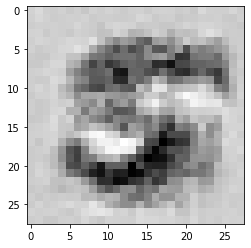

In [109]:
# run the network backwards, given a label, see what image it produces

# label to test
label = 5

# create array with length 10 and fill with 0.01
targets = numpy.zeros(output_n) + 0.01
# label we defined is index for target to make 0.99
targets[label] = 0.99

print(targets)

# query nn backwards
image_data = n.backquery(targets)

# plot image data
matplotlib.pyplot.imshow(image_data.reshape(28,28), cmap='Greys', interpolation='None')